In [1]:
from desc.compute.utils import get_transforms, get_profiles, get_params
from desc.compute import compute as compute_fun
from desc.backend import jnp
from desc.grid import Grid, LinearGrid
import desc.io
import desc.examples
from functools import partial
from jax import jit
from jax.experimental.ode import odeint as jax_odeint
import matplotlib.pyplot as plt
import numpy as np
import time
from desc.plotting import plot_surfaces, plot_section, plot_surfaces

eq = desc.io.load("equilibria/test_run.h5")
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
eq.solve()

def B_for_f_ratio_surface(psi_i):
    grid = LinearGrid(rho = np.sqrt(psi_i), M = 20, N = 20, NFP = eq.NFP)
    output = eq.compute("|B|", grid=grid)
    B = output["|B|"]
    print(B)
    return B

def B_for_f_ratio_fieldline(psi_i):
    coords = jnp.ones((250, 3)) #rho alpha zeta
    coords = coords.at[:, 0].set(coords[:, 0] * jnp.sqrt(psi_i))
    coords = coords.at[:, 2].set(jnp.linspace(0, 6 * jnp.pi, 250))

    start_time = time.time()
    print("starting map coords")
    print("--- %s seconds ---" % (time.time() - start_time))

    coords1 = eq.map_coordinates(
        coords=coords,
        inbasis=["rho", "alpha", "zeta"],
        outbasis=["rho", "theta", "zeta"],
        period=[jnp.inf, 2 * jnp.pi, jnp.inf],
        guess=None,
    )  # (2 * jnp.pi / eq.NFP)],

    grid = Grid(coords1, jitable=False, sort=False)
    output = eq.compute("|B|", grid=grid)

    B = output["|B|"]
    return B, coords1

def f_ratio(B):
    return np.sqrt(1-np.nanmin(B)/np.nanmax(B))

DESC version 0+untagged.5332.g4cefce1.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 2.65 GB available memory
Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 856
Number of objectives: 5346
Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 2.734e-06
         Total delta_x: 6.468e-02
         Iterations: 5
         Function evaluations: 9
         Jacobian evaluations: 6
Start of solver
Total (sum of squares):  2.876e-06, 
Total force:  1.355e+05 (N)
Total force:  2.398e-03 (normalized)
End of solver
Total (sum of squares):  2.734e-06, 
Total force:  1.321e+05 (N)
Total force:  2.338e-03 (normalized)


In [2]:
def rhs(w, t, a):
    #initial conditions
    psi, theta, zeta, vpar = w
    
    keys = ["B", "|B|", "grad(|B|)", "grad(psi)", "e^theta", "e^zeta"] # etc etc, whatever terms you need
    grid = Grid(jnp.array([jnp.sqrt(psi), theta, zeta]).T, jitable=True, sort=False)
    transforms = get_transforms(keys, eq, grid, jitable=True)
    profiles = get_profiles(keys, eq, grid, jitable=True)
    params = get_params(keys, eq)
    data = compute_fun(eq, keys, params, transforms, profiles)
    
    E, m_q = a
    m = m_q*1.6e-19

    b = (data["B"]/data["|B|"]) 
    mu = E/(m*data["|B|"]) - (vpar**2)/(2*data["|B|"])
    
    psidot = m_q*(1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2) * jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis = -1) * data["grad(psi)"])    
    thetadot = (vpar/data["|B|"]) * jnp.sum(data["B"] * data["e^theta"]) + m_q*(1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["e^theta"])
    zetadot = (vpar/data["|B|"]) * jnp.sum(data["B"]* data["e^zeta"]) 
    vpardot = -mu*jnp.sum(b * data["grad(|B|)"])    
    
    return jnp.array([psidot, thetadot, zetadot, vpardot])

In [3]:
def run(E_, q_, m_, t_i, t_f, nt_ ,psi_i, theta_i, zeta_i, vpar_i_ratio):
    e_charge = q_*1.6e-19
    m = m_*1.673e-27
    tmin = t_i
    tmax = t_f
    nt = nt_
    E = E_*3.52e6*e_charge
    m_q = m/e_charge

    v_parallel = vpar_i_ratio*jnp.sqrt(2*E/m)
    a_initial = [E, m_q]
    initial_conditions = [psi_i, theta_i, zeta_i, v_parallel]

    def solve_with_jax(a=None):
        initial_conditions_jax = jnp.array(initial_conditions, dtype=jnp.float64)
        a_jax = jnp.array(a_initial, dtype=jnp.float64)
        t_jax = jnp.linspace(tmin, tmax, nt)
        system_jit = jit(rhs)
        solution_jax = jax_odeint(partial(system_jit, a=a_jax), initial_conditions_jax, t_jax)
        return solution_jax
    
    sol = solve_with_jax()
    print(sol)

    return sol

In [10]:
E_ = 1
q_= 1
m_ = 1
t_i = 0 
t_f = 2e-5
nt_ = 150

# psi_i = coords1[min_index, 0]**2
# theta_i = coords1[min_index, 1]
# zeta_i = coords1[min_index, 2]

psi_i = 0.2*eq.Psi
theta_i = 0.1
zeta_i = 0.1

B_ = B_for_f_ratio_surface(psi_i=psi_i)
f = f_ratio(B_)

print(psi_i, theta_i, zeta_i)

vpar_i_ratio = 0.4*f
print(vpar_i_ratio)
sol = run(E_, q_, m_, t_i, t_f, nt_, psi_i, theta_i, zeta_i, vpar_i_ratio)

[ 0.43292486  0.60426533  4.41160922 ...  5.85492691  4.32620147
 34.1559147 ]
9.722571763276875 0.1 0.1
0.3999992345810782


2023-09-02 03:50:22.472693: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m26.349761791s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


[[ 9.72257176e+00  1.00000000e-01  1.00000000e-01  1.03790478e+07]
 [ 9.79084901e+00  8.14948119e-02  1.01818432e-01  1.10444419e+07]
 [ 9.85357291e+00  6.37177543e-02  1.03617423e-01  1.15233893e+07]
 [ 9.91096387e+00  4.67311081e-02  1.05373020e-01  1.18402645e+07]
 [ 9.96341616e+00  3.05545822e-02  1.07068669e-01  1.20185520e+07]
 [ 1.00114009e+01  1.51832066e-02  1.08693394e-01  1.20783562e+07]
 [ 1.00554009e+01  5.99709278e-04  1.10240219e-01  1.20358873e+07]
 [ 1.00958732e+01 -1.32176239e-02  1.11704940e-01  1.19037713e+07]
 [ 1.01332301e+01 -2.62902601e-02  1.13085224e-01  1.16916277e+07]
 [ 1.01678329e+01 -3.86367936e-02  1.14379969e-01  1.14066824e+07]
 [ 1.01999928e+01 -5.02716410e-02  1.15588863e-01  1.10543230e+07]
 [ 1.02299749e+01 -6.12045542e-02  1.16712096e-01  1.06385689e+07]
 [ 1.02580056e+01 -7.14406490e-02  1.17750160e-01  1.01624839e+07]
 [ 1.02842784e+01 -8.09807339e-02  1.18703735e-01  9.62851638e+06]
 [ 1.03089614e+01 -8.98218863e-02  1.19573617e-01  9.03880232e

/home/joaobiu/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


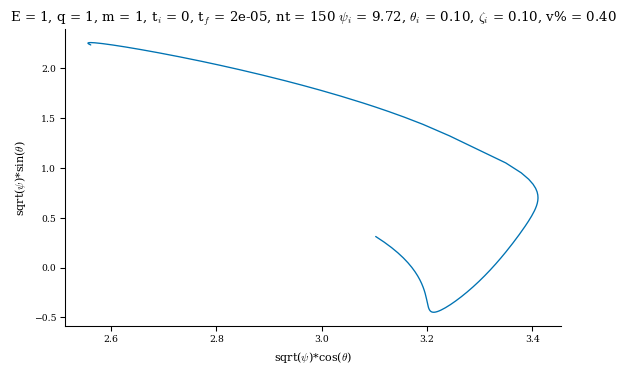

In [11]:
plt.plot(np.sqrt(sol[:, 0]) * np.cos(sol[:, 1]), np.sqrt(sol[:, 0]) * np.sin(sol[:, 1]))
plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.title(rf'E = {E_}, q = {q_}, m = {m_}, t$_i$ = {t_i}, t$_f$ = {t_f}, nt = {nt_} $\psi_i$ = {psi_i:.2f}, $\theta_i$ = {theta_i:.2f}, $\zeta_i$ = {zeta_i:.2f}, v% = {vpar_i_ratio:.2f}')
plt.show()

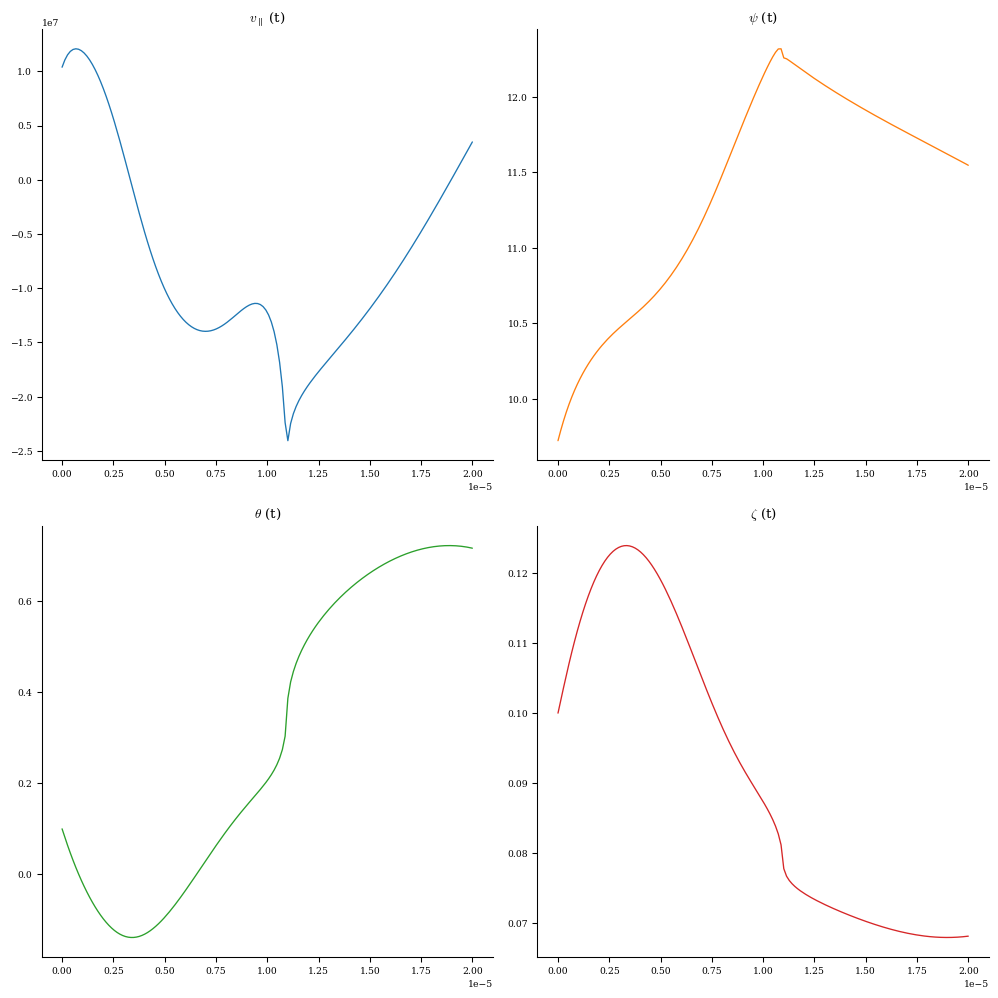

In [12]:
t = np.linspace(t_i, t_f, nt_)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(t, sol[:, 3], 'tab:blue')
axs[0, 0].set_title(r"$v_{\parallel}$ (t)")
axs[0, 1].plot(t, sol[:, 0], 'tab:orange')
axs[0, 1].set_title(r'$\psi$ (t)')
axs[1, 0].plot(t, sol[:, 1], 'tab:green')
axs[1, 0].set_title(r'$\theta$ (t)')
axs[1, 1].plot(t, sol[:, 2], 'tab:red')
axs[1, 1].set_title(r'$\zeta$ (t)')

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)